### GAN?

* 신경망은 기본적으로 정보를 압축, 정제, 축약 하는 역할을 한다
* 이 신경망을 반대로 뒤집으면? 숫자 레이블을 입력으로 주면 숫자 이미지를 만들어 낸다면?
* 이를 **백쿼리**라고 한다.


### 백쿼리
* 같은 원핫 인코딩 벡터면 같은 결과를 도출한다.
* 그 레이블을 나타내는 모든 훈련 데이터의 뭔가 평균적인 이미지가 나온다.


---


*하지만 우리가 얻고 싶은 건 평균적인 이미지가 아닌 입력에 맞는 서로다른 이미지*


### 적대적 훈련

* 2014년 이안 굿 펠로우가 발표한 네트워크 구조
* 생성자와 판별자를 통해 학습
* 생성자는 가짜 이미지를 만들어내고 판별자는 가짜로 생성된 이미지와 진짜 이미지를 구분하는 것
* 판별자를 속이면 생성자에게 보상을 판별기에 잡히면 생성자에 패널티를줌
* **판별기와 생성자가 서로 적대적 관계로 경쟁을 하게 되며, 서로를 뛰어넘으려고 노력하기 때문에 둘다 성능이 좋아지기 되는 구조가 바로 생성적 적대 신경망 GAN이다.**

### GAN 훈련

* 둘을 동시에 훈련시키면서 양쪽 모두 비슷한 수준으로 훈련이 이루어지도록 유도해야함


<font color='red'><b>step 1 :</b></font> 판별기에 실제 데이터를 주고 1.0 이라는 값이어야 한다고 알려준다.

오차가 발생하면 판별자를 업데이트

<font color='red'><b>step 2 :</b></font> 판별자에 생성자로부터 생성된 가짜 데이터를 보여주고 0.0 이어야한다고 알려준다.

판별자를 훈련하는 것이지만 생성자가 만들어낸 이미지를 주고, **오차를 통해 판별자만 업데이트**

<font color='red'><b>step 3 :</b></font> 판별기에 생성자의 결과를 보여주고, 생성자에 결과가 1.0 이어야한다고 알려준다.

생성자는 생성한 이미지를 판별자가 1.0으로 판단하도록 즉 판별자를 속여서 진짜처럼 분류하도록 하는 것으로 여기서 발생하는 오차는 생성자만을 업데이트하는데 사용한다.

### 단순한 1010 패턴으로 GAN 구현 해보기

In [ ]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
#데이터 생성
def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

generate_real(), generate_random(4)

(tensor([0.9430, 0.1479, 0.8941, 0.1320]),
 tensor([0.6770, 0.7910, 0.6814, 0.4601]))

### Discriminator Network

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        #부모 클래스 초기화
        super().__init__()

        #모델 정의
        self.model = nn.Sequential(
            nn.Linear(4,3),
            nn.Sigmoid(),
            nn.Linear(3,1),
            nn.Sigmoid()
        )

        #손실함수 설정
        self.loss = nn.MSELoss()

        #옵티마이저
        self.optimiser = torch.optim.SGD(self.parameters(),lr = 0.01)

        #로깅변수
        self.counter = 0;
        self.progress = []

        pass

    def forward(self, inputs):
        #모델 통과
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

    pass


### Discriminator Network Test

In [ ]:
D = Discriminator()

for i in range(10000):
    #진짜는 1로
    D.train(generate_real(), torch.FloatTensor([1.0]))
    #가짜는 0으로
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


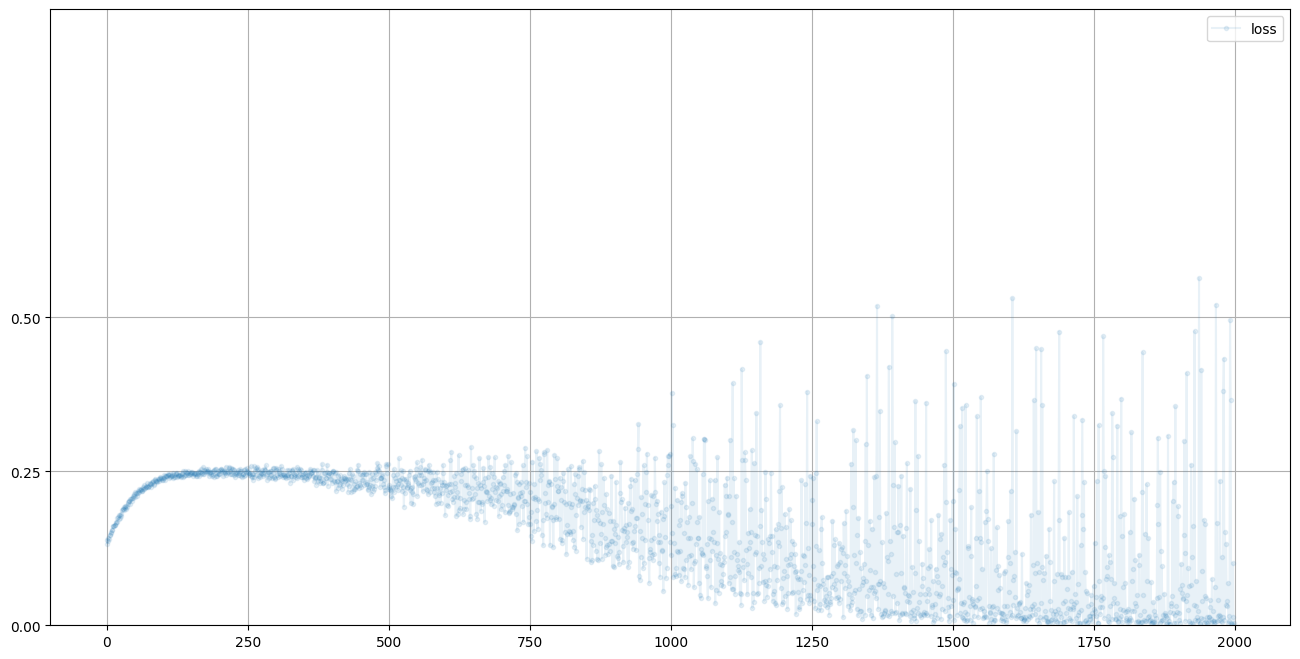

In [ ]:
D.plot_progress()

학습된 판별기에 임의의 진짜와 가짜값을 넣어보자

In [ ]:
print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.8086453676223755
0.15152858197689056


### Generator Network

* 마지막 출력 레이어는 판별자의 입력 레이어와 동일해야 연결가능
* 일반적으로 판별기를 반대로 뒤집은 형태로 시작
* 손실함수의 정의는 왜 없을까?
    - **생성자는 어떤 결과가 정답이 되어야 하는지 모름**
    - 생성자는 판별자에서 흘러온 기울기 오차를 통해서 업데이트 됨

* 학습
    - 생성자의 train() 함수를 넘겨주는 방식

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        #부모 클래스 초기화
        super().__init__()

        #모델 정의(판별자와 반대의 형태로)
        self.model = nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid()
        )

        #옵티마이저
        self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

        #로깅변수
        self.counter = 0;
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        #신경망 출력
        g_output = self.forward(inputs)

        #판별기로 전달
        d_output = D.forward(g_output)

        #오차 계산
        loss = D.loss(d_output, targets)

        #로깅
        self.counter+=1;
        if (self.counter %10 ==0):
            self.progress.append(loss.item())
            pass

        #기울기초기화 및 갱신 (생성자의 가중치에만 갱신)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

    pass

### Generator Network Test

In [ ]:
G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.4282, 0.6354, 0.5179, 0.4389], grad_fn=<SigmoidBackward0>)

### Train GAN

In [ ]:
%%time

# 생성자와 판별자 구축

D = Discriminator()
G = Generator()

image_list = []
epochs = 10000

for i in range(epochs):

    #step1 : 판별자 학습
    D.train(generate_real(), torch.FloatTensor([1.0]))

    #step2 : 생성자가 만든 가짜 데이터로 판별자 학습
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

    #step3 : 생성자 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    # 학습과정 기록
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 19 s, sys: 43.1 ms, total: 19 s
Wall time: 19.3 s


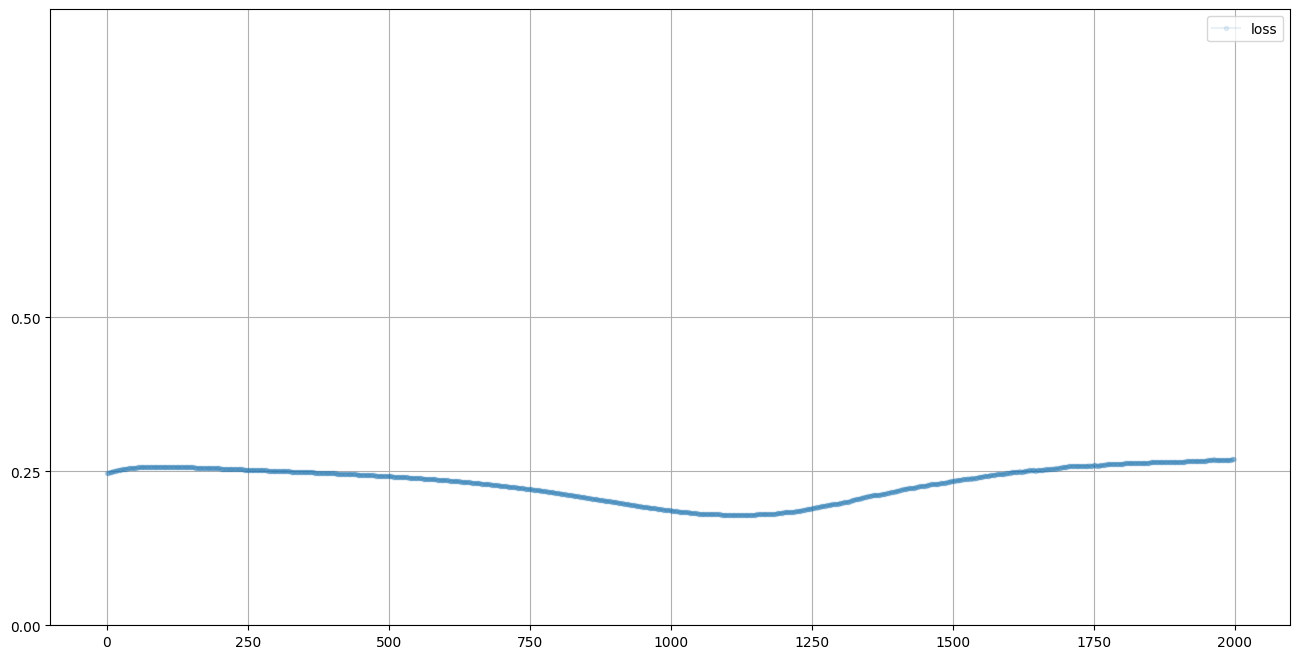

In [ ]:
D.plot_progress()

판별자 그래프 해석

* 0.25 근처에서 값이 맴돈다 -> 확실한 1,0이 아니라 애매한 0.5를 결과로 내고 있으며, 우리는 MSE를 사용했기 때문에 0.5의 제곱인 0.25로 수렴하는 것
* 중간에 손실이 조금 떨어지고 후반부에 다시 손실이 0.25로 튀어오름 -> 좋은 징조로 판별자가 구별하기 쉽지 않은 데이터를 생성자가 만들어냈다는것

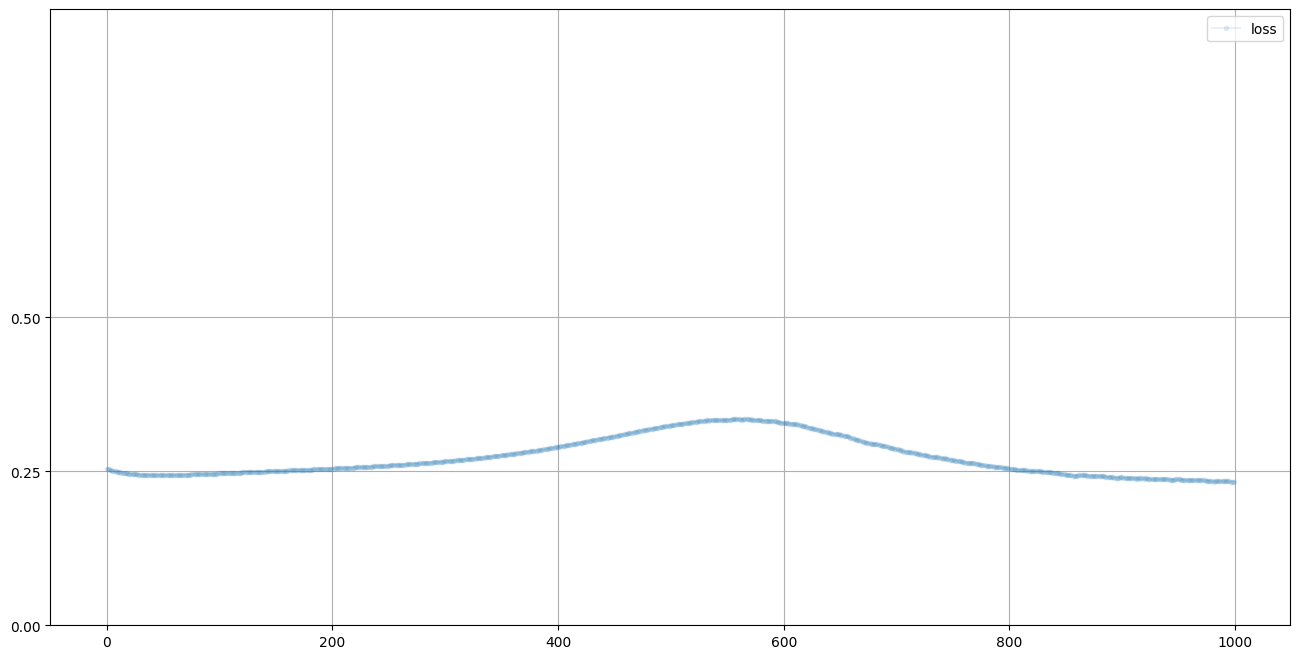

In [ ]:
G.plot_progress()

생성자 그래프 해석
* 중반에 손실이 증가 -> 생성자가 판별자를 속일 수 있을 정도로 성능이 조금 향상

학습한 생성자의 생성 결과물
- 실제로 1010 패턴을 생성하려고 했음을 확인할 수 있다


In [ ]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9372, 0.0534, 0.8980, 0.0484], grad_fn=<SigmoidBackward0>)

### 학습과정 시각화

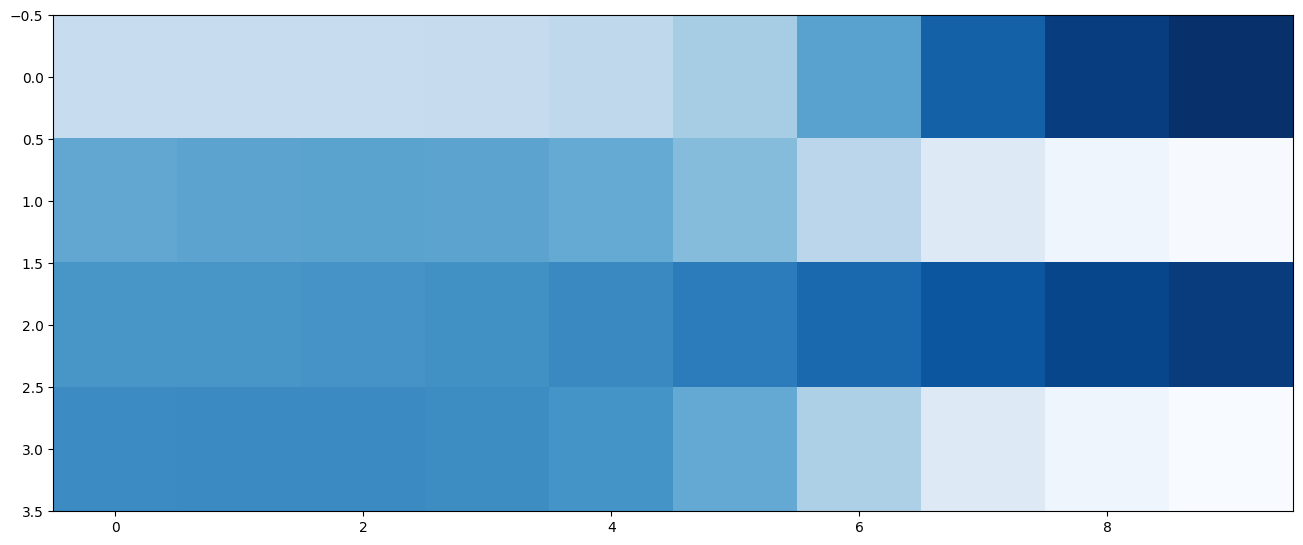

In [ ]:
plt.figure(figsize = (16,8))

plt.imshow(np.array(image_list).T, interpolation='none', cmap='Blues')